# Датасет Кати

In [1]:
from __future__ import division, print_function, unicode_literals

import sys
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
import IPython as IPy
import sklearn as skl
from sklearn.model_selection import train_test_split

import os
import tarfile
import urllib
import pickle

import joblib

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
from clintraj_qi import *
from clintraj_optiscale import *
from clintraj_eltree import *
from clintraj_util import *
import scipy.stats

In [3]:
def save_obj(obj, name):
    os.makedirs("obj", exist_ok=True)
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [4]:
dataset = pd.read_csv('../datasets/chinese.csv', sep=',',index_col=[0])
dataset

,Qrst_dur,P_Q_duration,Q_T_duration,T_duration,P_duration,Heart_rate,f_label,sex,age
0,0.076632,NaN,0.279263,0.123100,NaN,171.184023,5,0,74
1,0.107158,NaN,0.298000,0.112200,NaN,187.826087,1,0,74
2,0.082800,NaN,0.284947,0.108200,NaN,186.244078,2,0,74
3,0.081500,NaN,0.314706,0.142556,NaN,185.546875,2,0,74
4,0.075053,NaN,0.268421,0.084762,NaN,170.239596,7,0,74
...,...,...,...,...,...,...,...,...,...
23995,0.104125,0.0,0.376000,0.153500,0.071875,75.942958,0,1,61
23996,0.100500,0.0,0.413750,0.193625,0.080750,75.598488,0,1,61
23997,0.094750,0.0,0.420625,0.190500,0.087500,75.062552,0,1,61
23998,0.091500,0.0,0.416125,0.178625,0.093750,74.775673,0,1,61


In [5]:
dataset['sex'].value_counts()

0    12576
1    11424
Name: sex, dtype: int64

In [6]:
for col in dataset:
    print(f'{col}: {dataset[col].isna().sum()} NaN vals')

Qrst_dur: 8 NaN vals
P_Q_duration: 3103 NaN vals
Q_T_duration: 14 NaN vals
T_duration: 13 NaN vals
P_duration: 3082 NaN vals
Heart_rate: 10 NaN vals
f_label: 0 NaN vals
sex: 0 NaN vals
age: 0 NaN vals


In [7]:
quantify_nans(dataset)

Missing values 6230 (3.2447916666666665%)
Number of complete rows: 19333 (80.55416666666666%)


In [8]:
X_data_raw = dataset

## План

Построим кучу деревьев на основе:
1. Масштабирования: нормализации, стандартизации, оптимизации (если это так можно назвать),
2. 2D/3D.

## 1. Обработка датасета

### Нормализация и стандартизация

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),
                         ('mm_scaler', MinMaxScaler()),
                        ])

num_pipeline_std = Pipeline([('imputer', SimpleImputer(strategy="median")),
                         ('mm_scaler', StandardScaler()),
                        ])

X_data_prep = num_pipeline.fit_transform(X_data_raw) 
X_data_prep_std = num_pipeline_std.fit_transform(X_data_raw) 
X_prep = pd.DataFrame(X_data_prep)
X_prep_std = pd.DataFrame(X_data_prep_std)

### Оптимизация

In [10]:
variable_types, binary, continuous, ordinal = detect_variable_type(dataset, 10, verbose=False)
dfq,replacement_info = quantify_dataframe_univariate(dataset, variable_types)
with open('temp.txt','w') as fid:
    fid.write(replacement_info)

Matrix shape: (19333, 8)
Effective linear dimension 7
Full matrix shape (24000, 8)


,Qrst_dur,P_Q_duration,Q_T_duration,T_duration,P_duration,Heart_rate,f_label,sex,age
0,0.076632,0.151448,0.279263,0.123100,0.083777,171.184023,5,0,74.0
1,0.107158,0.151448,0.298000,0.112200,0.083776,187.826087,1,0,74.0
2,0.082800,0.151448,0.284947,0.108200,0.083776,186.244078,2,0,74.0
3,0.081500,0.151448,0.314706,0.142556,0.083776,185.546875,2,0,74.0
4,0.075053,0.151448,0.268421,0.084762,0.083776,170.239596,7,0,74.0
...,...,...,...,...,...,...,...,...,...
23995,0.104125,0.000000,0.376000,0.153500,0.071875,75.942958,0,1,61.0
23996,0.100500,0.000000,0.413750,0.193625,0.080750,75.598488,0,1,61.0
23997,0.094750,0.000000,0.420625,0.190500,0.087500,75.062552,0,1,61.0
23998,0.091500,0.000000,0.416125,0.178625,0.093750,74.775673,0,1,61.0


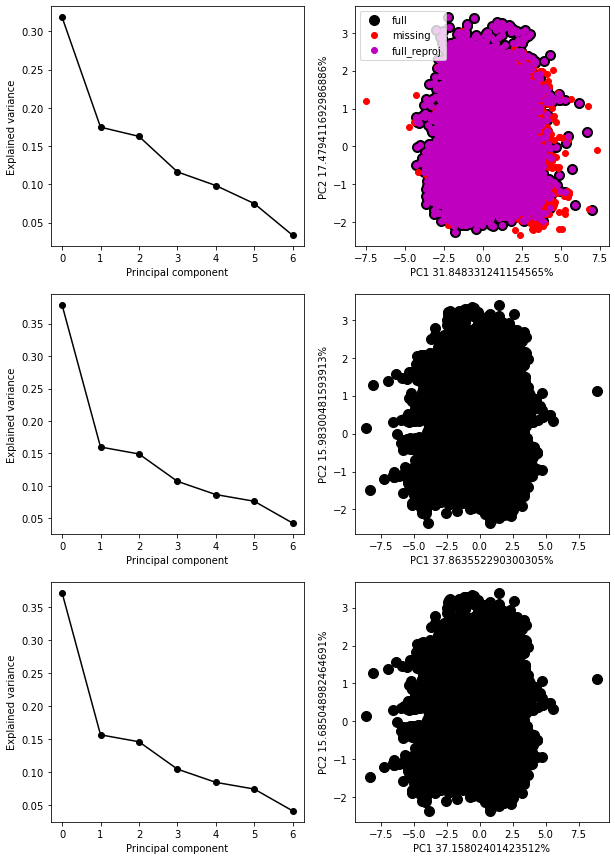

In [11]:
dfq_imputed = SVDcomplete_imputation_method(dfq, variable_types, verbose=True,num_components=-1)
dequant_info = invert_quant_info(load_quantification_info('temp.txt'))
df_imputed = dequantify_table(dfq_imputed,dequant_info)
display(df_imputed)

Removing  0 columns

 Initial Q2: 1.4579507169879662
Initial quantification table:
[array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])]
Monotonicity: (True, 1.0)
Iteration 0 Q2= 1.4579507169879662
Iteration 1 Q2= 1.4579507169879609
Iteration 2 Q2= 1.4581283421278997
Iteration 3 Q2= 1.4583306305819317
Iteration 4 Q2= 1.458389565078356
Iteration 5 Q2= 1.4584044505590352
Iteration 6 Q2= 1.458406301956428
Iteration 7 Q2= 1.4584063961346656
Iteration 8 Q2= 1.458406401066565

 Q2 after update: 1.4584064013387774
Final quantification table:
[array([-0.6053044 ,  0.6873999 ,  0.92252734,  1.12771077,  1.31237072,
        1.73381309,  1.73381309,  2.01320029,  2.3047956 ,  2.48855053])]
Monotonicity: (True, 9.039629045304309e-10)


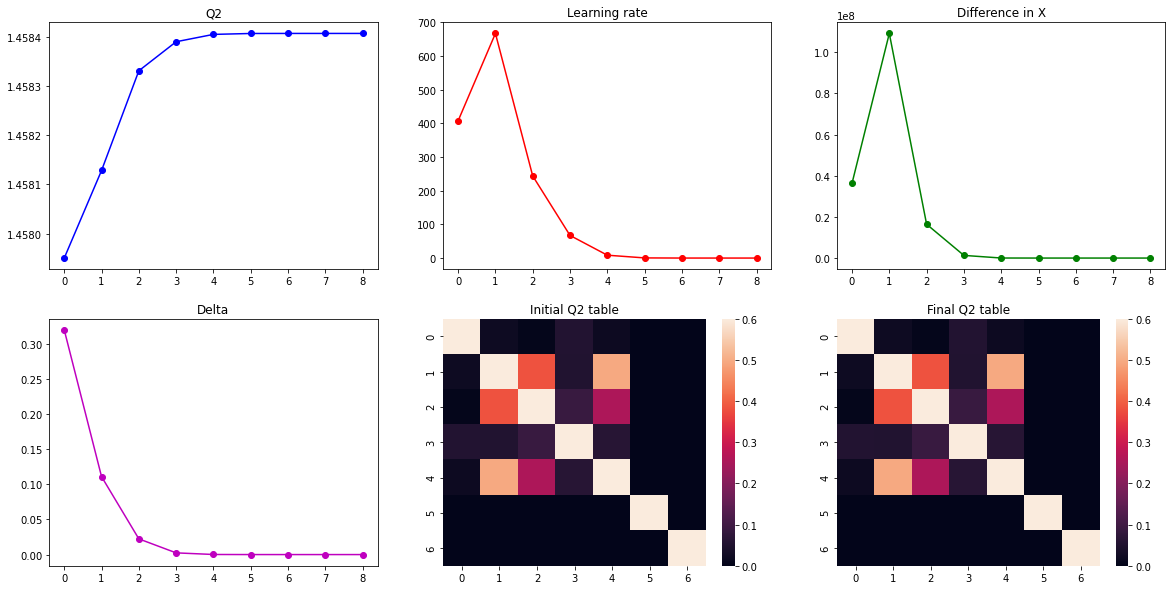

In [12]:
df = remove_constant_columns_from_dataframe(df_imputed)
variable_names = [str(s) for s in df.columns[1:]]
X = df[df.columns[1:]].to_numpy()
X_orig_opt = X
X_before_scaling = X.copy()
X_opt, cik = optimal_scaling(X,variable_types,verbose=True,vmax=0.6)

## 2. Построение деревьев

In [13]:
import elpigraph
from elpigraph import computeElasticPrincipalTree

nnodes = 50
X_norm = X_prep.to_numpy()
X_std = X_prep_std.to_numpy()

In [14]:
def do_PCA(X):
    # reduced_dimension = 12
    X_to_PCA = scipy.stats.zscore(X)
    pca = PCA(n_components=X_to_PCA.shape[1],svd_solver='full')
    Y = pca.fit_transform(X_to_PCA)
    v = pca.components_.T
    mean_val = np.mean(X_to_PCA,axis=0)
    return Y[:], v, mean_val # ,0:reduced_dimension]

X_pca_norm, components_norm, mnval_norm = do_PCA(X_norm)
X_pca_std, components_std, mnval_std = do_PCA(X_std)
X_pca_opt, components_opt, mnval_opt = do_PCA(X_opt)

In [15]:
def create_extended_tree(X, nnodes):
    tree_elpi = computeElasticPrincipalTree(X, nnodes, alpha=0.01, Mu=0.1, Lambda=0.05, FinalEnergy='Penalized')[0]
    prune_the_tree(tree_elpi)
    tree_extended = ExtendLeaves_modified(X, tree_elpi, Mode = "QuantDists", ControlPar = .5, DoSA = False)
    return tree_extended

'''
tree_norm = create_extended_tree(X_pca_norm, 50)
tree_std = create_extended_tree(X_pca_std, 50)
tree_opt = create_extended_tree(X_pca_opt, 50)
'''

'\ntree_norm = create_extended_tree(X_pca_norm, 50)\ntree_std = create_extended_tree(X_pca_std, 50)\ntree_opt = create_extended_tree(X_pca_opt, 50)\n'

In [16]:
'''
save_obj(tree_norm, "chinese_tree_norm")
save_obj(tree_std, "chinese_tree_std")
save_obj(tree_opt, "chinese_tree_opt")
'''

'\nsave_obj(tree_norm, "chinese_tree_norm")\nsave_obj(tree_std, "chinese_tree_std")\nsave_obj(tree_opt, "chinese_tree_opt")\n'

In [17]:
tree_norm = load_obj("chinese_tree_norm")
tree_std = load_obj("chinese_tree_std")
tree_opt = load_obj("chinese_tree_opt")

In [18]:
X_orig_imputer = SimpleImputer(strategy="median").fit_transform(dataset)
X_orig_imputer

array([[ 0.07663158,  0.14711111,  0.27926316, ...,  5.        ,
         0.        , 74.        ],
       [ 0.10715789,  0.14711111,  0.298     , ...,  1.        ,
         0.        , 74.        ],
       [ 0.0828    ,  0.14711111,  0.28494737, ...,  2.        ,
         0.        , 74.        ],
       ...,
       [ 0.09475   ,  0.        ,  0.420625  , ...,  0.        ,
         1.        , 61.        ],
       [ 0.0915    ,  0.        ,  0.416125  , ...,  0.        ,
         1.        , 61.        ],
       [ 0.086625  ,  0.        ,  0.415625  , ...,  0.        ,
         1.        , 61.        ]])

In [19]:
X_orig_opt

array([[ 0.15144791,  0.27926316,  0.1231    , ...,  5.        ,
         0.        , 74.        ],
       [ 0.15144811,  0.298     ,  0.1122    , ...,  1.        ,
         0.        , 74.        ],
       [ 0.15144808,  0.28494737,  0.1082    , ...,  2.        ,
         0.        , 74.        ],
       ...,
       [ 0.        ,  0.420625  ,  0.1905    , ...,  0.        ,
         1.        , 61.        ],
       [ 0.        ,  0.416125  ,  0.178625  , ...,  0.        ,
         1.        , 61.        ],
       [ 0.        ,  0.415625  ,  0.17725   , ...,  0.        ,
         1.        , 61.        ]])

## 3. Визуализация деревьев

### Окраска ветвей деревьев

In [20]:
def tree_visualization(tree_elpi, X, X_orig, components_vec, mean_val):
    vec_labels_by_branches = partition_data_by_tree_branches(X, tree_elpi)

    partition, dists = elpigraph.src.core.PartitionData(X = X, NodePositions = tree_elpi['NodePositions'], 
                                                        SquaredX = np.sum(X**2,axis=1,keepdims=1),
                                                        MaxBlockSize = 100000000, TrimmingRadius = np.inf
                                                        )
    partition_by_node = np.zeros(len(partition))
    for i,p in enumerate(partition):
        partition_by_node[i] = p[0]

    variable_names = [str(s) for s in dataset.columns[1:]]
    visualize_eltree_with_data(tree_elpi, X, X_orig, components_vec, mean_val, 'k', variable_names,
                              Color_by_partitioning = True, visualize_partition = vec_labels_by_branches)

In [35]:
figsize=(15, 12)

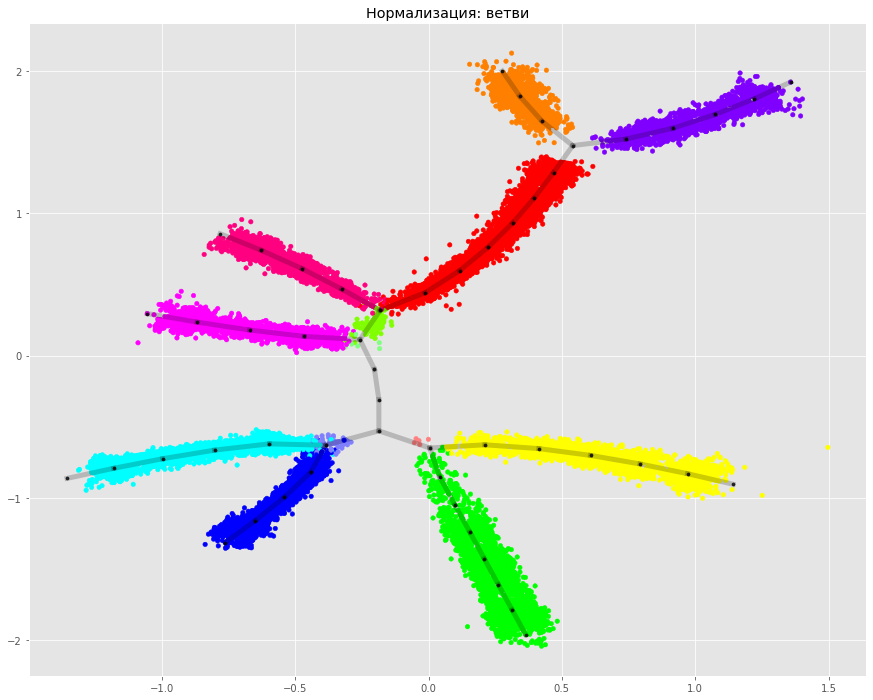

In [36]:
fig = plt.figure(figsize=figsize)
tree_visualization(tree_norm, X_pca_norm, X_orig_imputer, components_norm, mnval_norm)
plt.title("Нормализация: ветви")
plt.show()

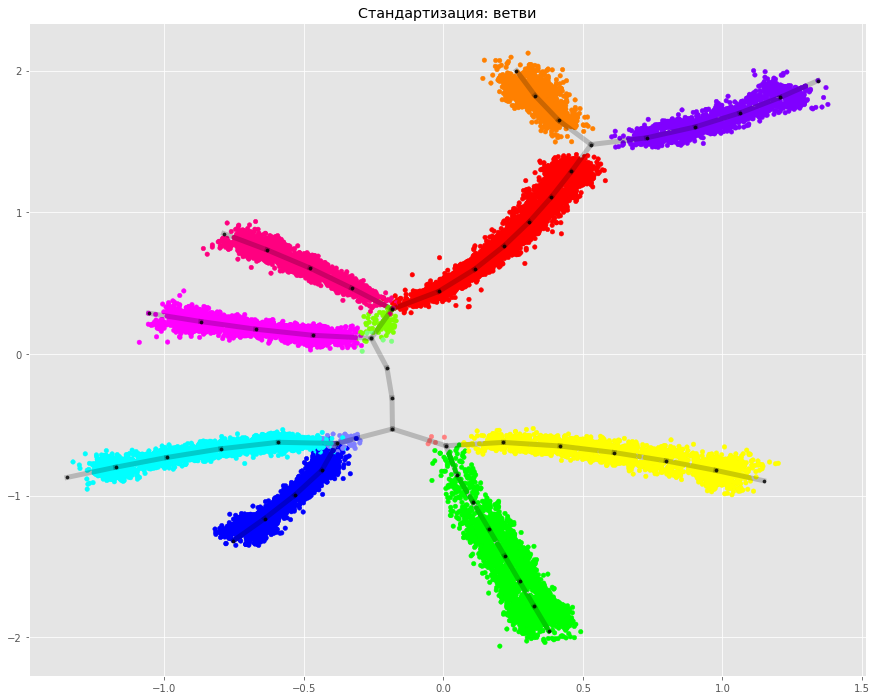

In [37]:
fig = plt.figure(figsize=figsize)
tree_visualization(tree_std, X_pca_std, X_orig_imputer, components_std, mnval_std)
plt.title("Стандартизация: ветви")
plt.show()

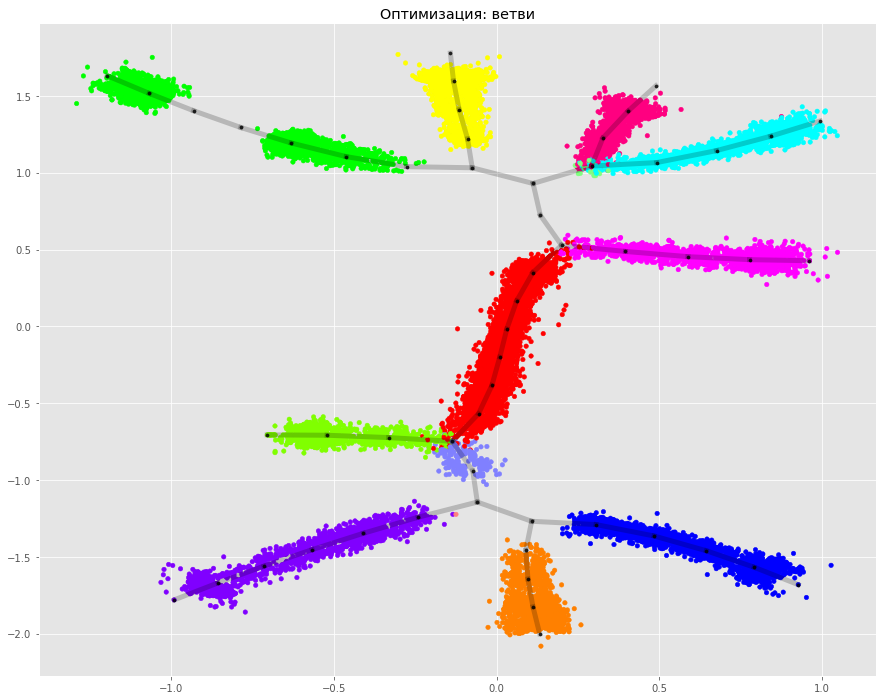

In [38]:
fig = plt.figure(figsize=figsize)
tree_visualization(tree_opt, X_pca_opt, X_orig_opt, components_opt, mnval_opt)
plt.title("Оптимизация: ветви")
plt.show()

### Визуализация атрибутов

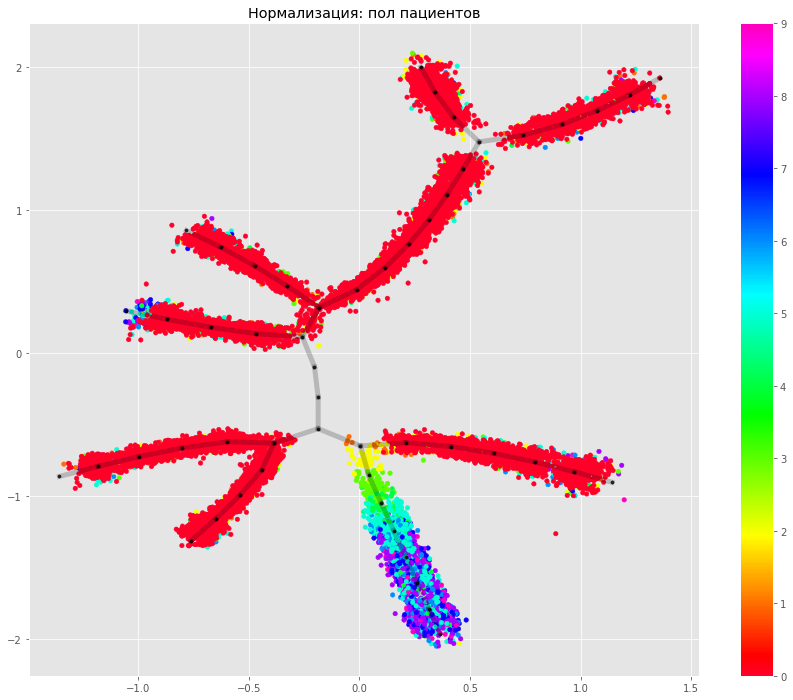

In [39]:
fig = plt.figure(figsize=figsize)
visualize_eltree_with_data(tree_norm, X_pca_norm, X_orig_imputer, components_norm, mnval_norm, 'k', variable_names,
                           Color_by_feature='sex', cmap='gist_rainbow', add_color_bar=True)
plt.title("Нормализация: пол пациентов")
plt.show()

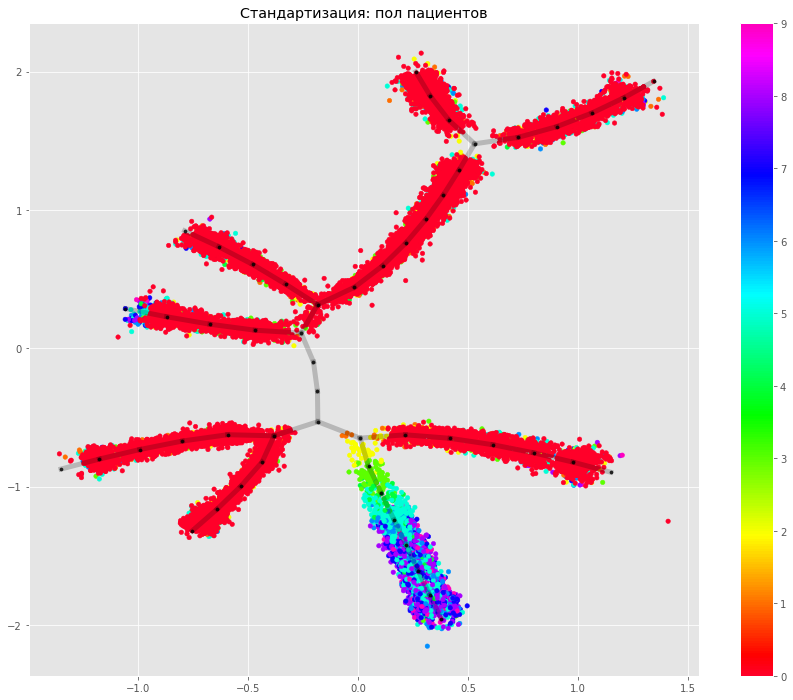

In [40]:
fig = plt.figure(figsize=figsize)
# tree_extended, X, X_original, v, mean_val, 'k', variable_names
visualize_eltree_with_data(tree_std, X_pca_std, X_orig_imputer, components_std, mnval_std, 'k', variable_names,
                           Color_by_feature='sex', cmap='gist_rainbow', add_color_bar=True)
plt.title("Стандартизация: пол пациентов")
plt.show()

### Исследование дерева на оптимизированном датасете

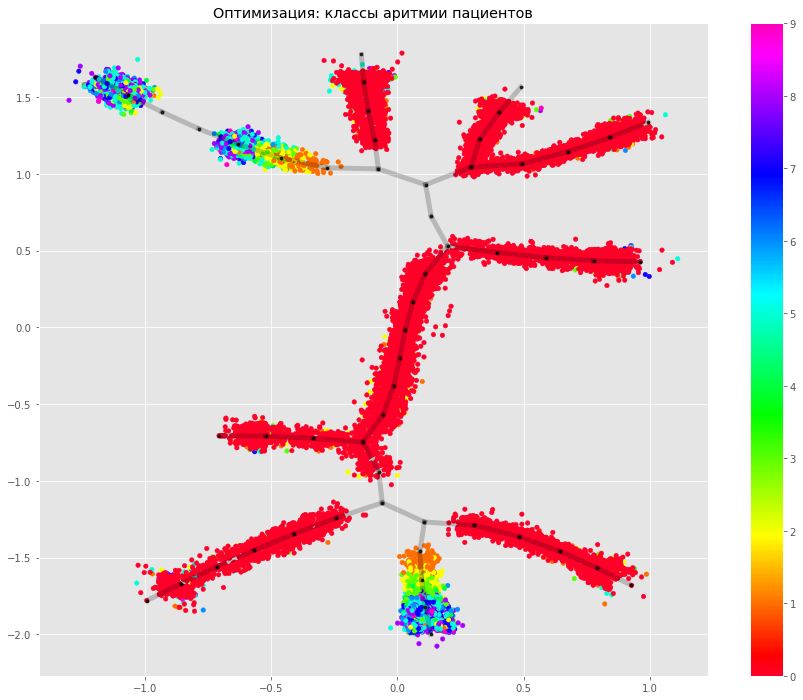

In [41]:
fig = plt.figure(figsize=figsize)
# tree_extended, X, X_original, v, mean_val, 'k', variable_names
visualize_eltree_with_data(tree_opt, X_pca_opt, X_orig_opt, components_opt, mnval_opt, 'k', variable_names,
                           Color_by_feature='f_label', cmap='gist_rainbow', add_color_bar=True)
plt.title("Оптимизация: классы аритмии пациентов")
plt.show()

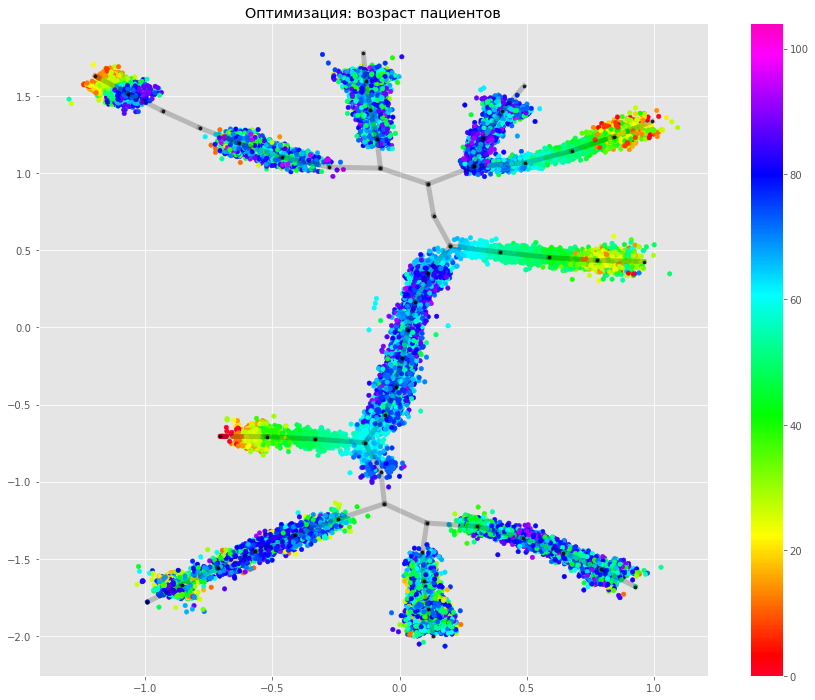

In [42]:
fig = plt.figure(figsize=figsize)
# tree_extended, X, X_original, v, mean_val, 'k', variable_names
visualize_eltree_with_data(tree_opt, X_pca_opt, X_orig_opt, components_opt, mnval_opt, 'k', variable_names,
                           Color_by_feature='age', cmap='gist_rainbow', add_color_bar=True)
plt.title("Оптимизация: возраст пациентов")
plt.show()

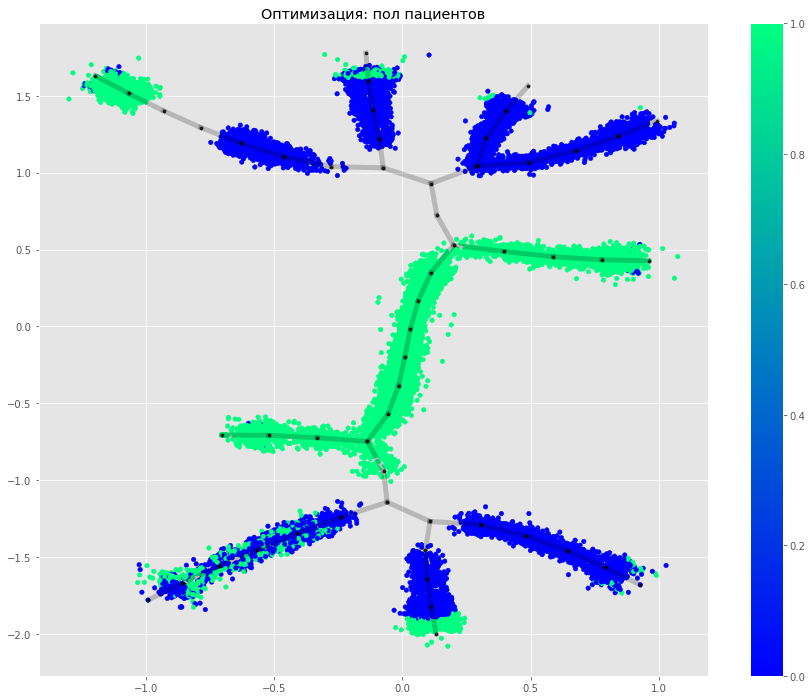

In [43]:
fig = plt.figure(figsize=figsize)
# tree_extended, X, X_original, v, mean_val, 'k', variable_names
visualize_eltree_with_data(tree_opt, X_pca_opt, X_orig_opt, components_opt, mnval_opt, 'k', variable_names,
                           Color_by_feature='sex', cmap='winter', add_color_bar=True)
plt.title("Оптимизация: пол пациентов")
plt.show()

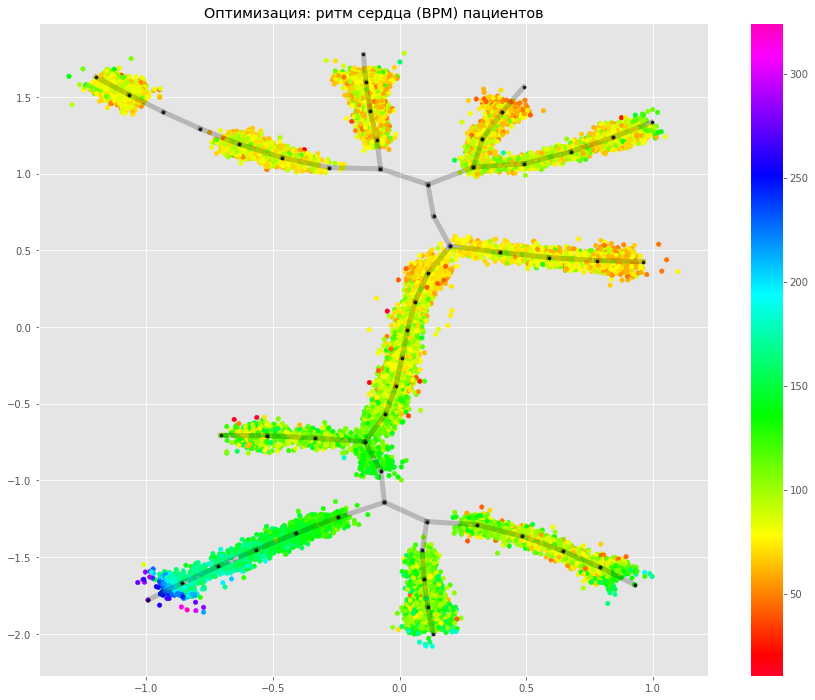

In [44]:
fig = plt.figure(figsize=figsize)
# tree_extended, X, X_original, v, mean_val, 'k', variable_names
visualize_eltree_with_data(tree_opt, X_pca_opt, X_orig_opt, components_opt, mnval_opt, 'k', variable_names,
                           Color_by_feature='Heart_rate', cmap='gist_rainbow', add_color_bar=True)
plt.title("Оптимизация: ритм сердца (BPM) пациентов")
plt.show()

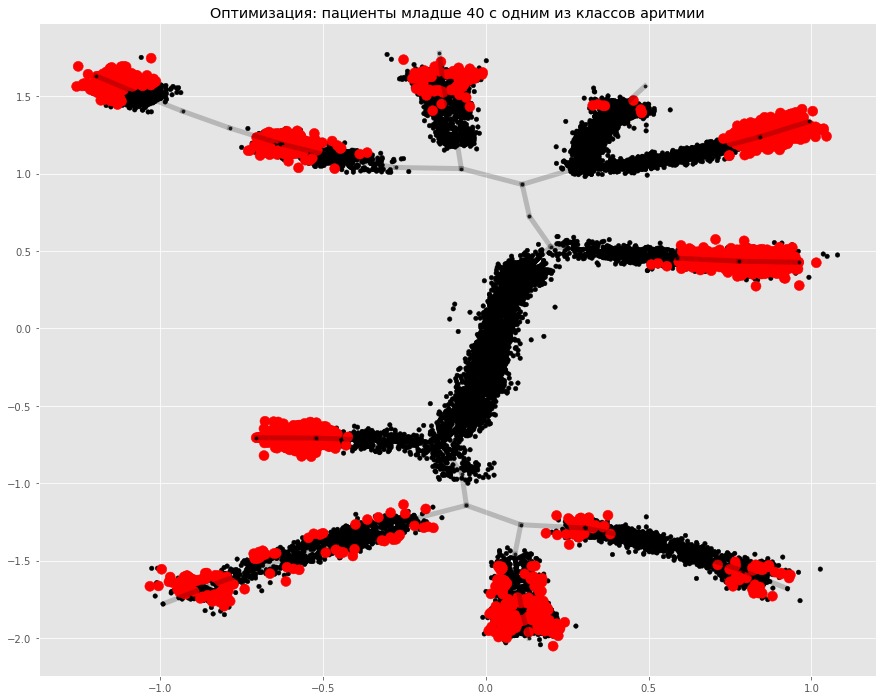

In [53]:
some_age = 40
fig = plt.figure(figsize=figsize)
inds = np.where((X_orig_opt[:,variable_names.index('age')] <= some_age) & 
                (X_orig_opt[:,variable_names.index('f_label')] >= 0))[0]
colors = ['k' for i in range(len(X))]
for i in inds:
    colors[i] = 'r'
visualize_eltree_with_data(tree_opt, X_pca_opt, X_orig_opt, components_opt, mnval_opt, colors, variable_names,
                          highlight_subset=inds, cmap='hot')
plt.title(f"Оптимизация: пациенты младше {some_age} с одним из классов аритмии")
plt.show()